# Bayesian inference with PyMC
## Truncated inverse gaussian distribution (aka Wald) for the likelihood

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc3 as pm
print(pm.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(123)

import scipy.stats as st
import scipy.special as ss

import theano.tensor as tt

C:\Miniconda3\envs\pymc3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.4.1


In [3]:
def normal_pdf(x, mu, sigma):
    return np.exp(-((x-mu)**2)/(2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

In [4]:
def normal_cdf(x, mu, sigma):
    return 0.5 * (1 + ss.erf((x-mu)/(sigma*np.sqrt(2))))

In [5]:
def inverse_gaussian_pdf(x, mu, lam):
    return np.sqrt(lam/(2*np.pi*(x**3.0))) * np.exp((-lam*(x-mu)**2)/(2*x*(mu**2)))

In [6]:
def inverse_gaussian_cdf(x, mu, lam):
    arg1 = np.sqrt(lam/x) * (x/mu - 1)
    arg2 = -np.sqrt(lam/x) * (x/mu + 1)
    
    cdf = normal_cdf(arg1, mu=0, sigma=1) # standard normal distribution
    cdf += (np.exp(2*(lam/mu)) * normal_cdf(arg2, mu=0, sigma=1))

    return cdf

In [7]:
def inverse_gaussian_pdf_truncated(x, mu, lam, upper):
    pdf = inverse_gaussian_pdf(x=x, mu=mu, lam=lam)
    pdf[x>upper] = 0
    # renormalize
    pdf /= inverse_gaussian_cdf(x=upper, mu=mu, lam=lam)
    
    return pdf

In [8]:
# generate Inverse Gaussian observations
mu_true = 3
lam_true = 2

y_wald = np.random.wald(mean=mu_true, scale=lam_true, size=100000)

range_x = 0.01
x_wald = np.arange(0, np.max(y_wald), range_x)

upper = 5

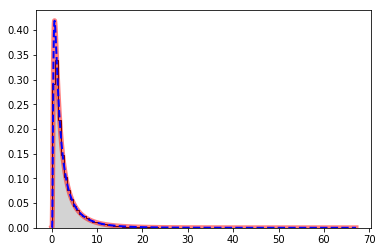

In [9]:
# Check if the defined function is working
plt.hist(y_wald, bins=100, density=True, histtype='stepfilled', facecolor='lightgray', edgecolor='k');

plt.plot(x_wald, st.invgauss.pdf(x_wald, mu=mu_true/lam_true, scale=lam_true), 'r-', alpha=0.5, lw=5)
plt.plot(x_wald, inverse_gaussian_pdf(x_wald, mu=mu_true, lam=lam_true), 'b--', alpha=1, lw=2);

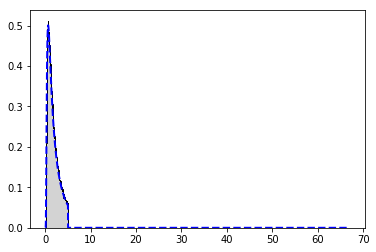

In [10]:
# Check if the defined function is working
plt.hist(y_wald[y_wald<=upper], bins=100, density=True, histtype='stepfilled', facecolor='lightgray', edgecolor='k');
plt.plot(x_wald, inverse_gaussian_pdf_truncated(x_wald, mu=mu_true, lam=lam_true, upper=upper), 'b--', alpha=1, lw=2);

## Estimate parameter with PyMC3

In [11]:
obs = y_wald[y_wald<=upper]
obs

array([0.8619247 , 0.9441932 , 0.50658543, ..., 0.91440762, 1.00474599,
       4.77206226])

In [12]:
def normal_logcdf_theano(x, mu, sigma):
    return tt.log(0.5 * (1 + tt.erf((x-mu)/(sigma*tt.sqrt(2)))))

In [13]:
def normal_cdf_theano(x, mu, sigma):
    return 0.5 * (1 + tt.erf((x-mu)/(sigma*tt.sqrt(2))))

In [14]:
def inverse_gaussian_cdf_theano(x, mu, lam):
    arg1 = tt.sqrt(lam/x) * (x/mu - 1)
    arg2 = -tt.sqrt(lam/x) * (x/mu + 1)
    
    cdf = normal_cdf_theano(arg1, mu=0, sigma=1) # standard normal distribution
    cdf += (tt.exp(2*lam/mu) * normal_cdf_theano(arg2, mu=0, sigma=1))

    return cdf

In [15]:
def inverse_gaussian_logcdf_theano(x, mu, lam):
    arg1 = tt.sqrt(lam/x) * (x/mu - 1)
    arg2 = -tt.sqrt(lam/x) * (x/mu + 1)
    
    cdf = normal_cdf_theano(arg1, mu=0, sigma=1) # standard normal distribution
    cdf += (tt.exp(2*lam/mu) * normal_cdf_theano(arg2, mu=0, sigma=1))

    return tt.log(cdf)

In [16]:
with pm.Model() as model:
    
    mu = pm.HalfNormal('mu', sd=10)
    lam = pm.HalfNormal('lam', sd=10)
    
    y_likelihood = pm.Wald('y_likelihood', mu, lam, observed=obs)
    # potential works the same as target +=... in Stan, tt.switch works the same as ifelse
    # see: https://discourse.pymc.io/t/truncated-inverse-normal-distribution-also-known-as-wald-distribution/1125
    upper_bound = pm.Potential('upper_bound', tt.switch(tt.gt(obs, upper), -np.inf, -inverse_gaussian_logcdf_theano(upper, mu, lam)))
    
    trace = pm.sample(draws=5000, chains=2, cores=2, tune=1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam_log__, mu_log__]


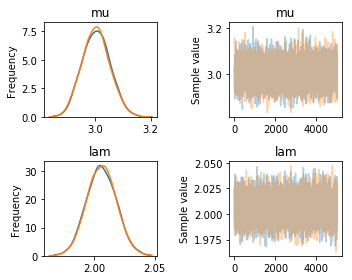

In [17]:
pm.traceplot(trace, figsize=(5, 4));

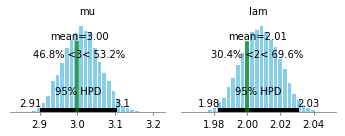

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
pm.plot_posterior(trace, round_to=2, ref_val=[mu_true, lam_true], ax=ax);

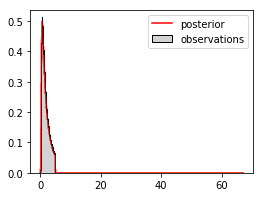

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.hist(obs, 
         bins=100, density=True, histtype='stepfilled', facecolor='lightgray', edgecolor='k',
         label='observations');

for mu, lam in zip(trace['mu'][::100], trace['lam'][::100]):
    pdf = inverse_gaussian_pdf_truncated(x_wald, mu, lam, upper)
    plt.plot(x_wald, pdf, '-r', alpha=0.01)

plt.plot(np.nan, np.nan, '-r', label='posterior')
plt.legend();

## Try implementation from PyMC3 PR

https://github.com/pymc-devs/pymc3/pull/2688/commits/f3d929519b1692398d0620c5f635248306a1aff5

In [20]:
def normallogcdf(value, mu=0, sd=1):
    """
    Normal log CDF. Useful for many log CDF methods.
    """
    z = (value - mu) / sd
    return tt.switch(
        tt.lt(z, -1.0),
        tt.log(tt.erfcx(-z / tt.sqrt(2.)) / 2.) -
        tt.sqr(z) / 2,
        tt.log1p(-tt.erfc(z / tt.sqrt(2.)) / 2.)
    )

In [21]:
def logcdf(mu, lam, alpha, value):
        # Distribution parameters
        alpha = 0
        value -= alpha
        q = value / mu
        l = lam * mu
        r = tt.sqrt(value * lam)

        a = normallogcdf((q - 1.)/r)
        b = 2./l + normallogcdf(-(q + 1.)/r)
        
        return tt.switch(
            (
                # Left limit
                tt.lt(value, 0) |
                (tt.eq(value, 0) & tt.gt(mu, 0) & tt.lt(lam, np.inf)) |
                (tt.lt(value, mu) & tt.eq(lam, 0))
            ),
            -np.inf,
            tt.switch(
                (
                    # Right limit
                    tt.eq(value, np.inf) |
                    (tt.eq(lam, 0) & tt.gt(value, mu)) |
                    (tt.gt(value, 0) & tt.eq(lam, np.inf)) |
                    # Degenerate distribution
                    (
                        tt.lt(mu, np.inf) &
                        tt.eq(mu, value) &
                        tt.eq(lam, 0)
                    ) |
                    (tt.eq(value, 0) & tt.eq(lam, np.inf))
                ),
                0,
                a + tt.log1p(tt.exp(b - a))
            )
        )


In [22]:
with pm.Model() as model:
    
    mu = pm.HalfNormal('mu', sd=10)
    lam = pm.HalfNormal('lam', sd=10)
    
    y_likelihood = pm.Wald('y_likelihood', mu, lam, observed=obs)
    # potential works the same as target +=... in Stan, tt.switch works the same as ifelse
    # see: https://discourse.pymc.io/t/truncated-inverse-normal-distribution-also-known-as-wald-distribution/1125
    upper_bound = pm.Potential('upper_bound', tt.switch(tt.gt(obs, upper), -np.inf, -logcdf(mu, lam, 0, upper)))
    
    trace = pm.sample(draws=5000, chains=2, cores=2, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam_log__, mu_log__]


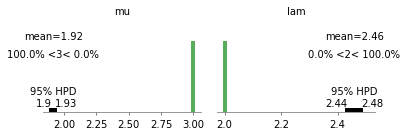

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
pm.plot_posterior(trace, round_to=2, ref_val=[mu_true, lam_true], ax=ax);

## Try Mathematica expression

In [ ]:
# def inversegaussian_logCDF(mu, lam, U):
    a = tt.erfc((tt.mul(tt.sqrt(lam), tt.sub(mu, U)) / tt.mul(tt.sqrt(2), mu, tt.sqrt(U))))
    b = tt.exp((tt.mul(2, lam) / mu))
    c = tt.erfc((tt.mul(tt.sqrt(lam), tt.add(mu, U)) / tt.mul(tt.sqrt(2), mu, tt.sqrt(U))))
    d = tt.sub(tt.log(tt.add(a, tt.mul(b, c))), tt.log(2))
    return d

In [58]:
with pm.Model() as model:
    
    mu = pm.HalfNormal('mu', sd=10, testval=1)
    lam = pm.HalfNormal('lam', sd=10, testval=1)
    
    y_likelihood = pm.Wald('y_likelihood', mu, lam, observed=obs)
    # potential works the same as target +=... in Stan, tt.switch works the same as ifelse
    # see: https://discourse.pymc.io/t/truncated-inverse-normal-distribution-also-known-as-wald-distribution/1125
    upper_bound = pm.Potential('upper_bound', tt.switch(tt.gt(obs, upper), -np.inf, -inversegaussian_logCDF(mu, lam, upper)))
    
    trace = pm.sample(draws=5000, chains=4, cores=4, tune=1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [lam_log__, mu_log__]


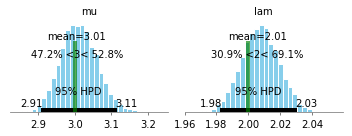

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
pm.plot_posterior(trace, round_to=2, ref_val=[mu_true, lam_true], ax=ax);